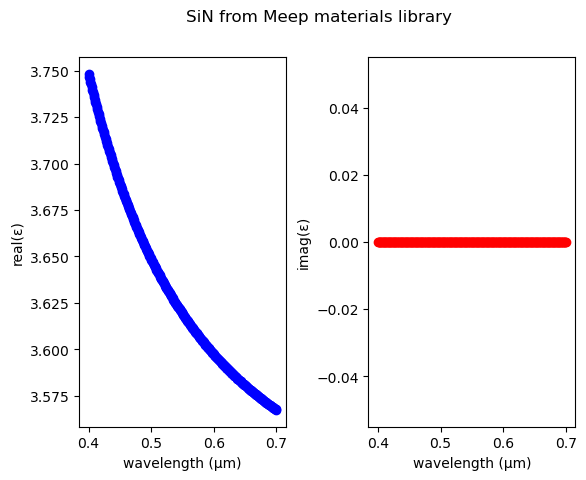

In [11]:
import meep as mp
import meep.adjoint as mpa
from meep.materials import Si3N4
import numpy as np
import matplotlib.pyplot as plt

um_scale = 1
resolution = 20

SiN_range = mp.FreqRange(min=um_scale / 1.5, max=um_scale / 0.10)
SiN_frq1 = 0.000077 / um_scale
SiN_gam1 = 0
SiN_sig1 = 2.006395
SiN_frq2 = 8.120892 / um_scale
SiN_gam2 = 0
SiN_sig2 = 2.487814

SiN_susc = [
    mp.LorentzianSusceptibility(frequency=SiN_frq1, gamma=SiN_gam1, sigma=SiN_sig1),
    mp.LorentzianSusceptibility(frequency=SiN_frq2, gamma=SiN_gam2, sigma=SiN_sig2),
]
Si3N4 = mp.Medium(
    epsilon=1.0, E_susceptibilities=SiN_susc, valid_freq_range=SiN_range
)

wvl_min = 0.4 *  um_scale # units of μm
wvl_max = 0.7 *  um_scale# units of μm
nwvls = 300
wvls = np.linspace(wvl_min, wvl_max, nwvls)

Si3N4_epsilon = np.array([Si3N4.epsilon(1/w)[0][0] for w in wvls])

plt.subplot(1,2,1)
plt.plot(wvls,np.real(Si3N4_epsilon),'bo-')
plt.xlabel('wavelength (μm)')
plt.ylabel('real(ε)')

plt.subplot(1,2,2)
plt.plot(wvls,np.imag(Si3N4_epsilon),'ro-')
plt.xlabel('wavelength (μm)')
plt.ylabel('imag(ε)')

plt.suptitle('SiN from Meep materials library')
plt.subplots_adjust(wspace=0.4)
plt.savefig("epsilon")

-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 2D dimensions.
Computational cell is 10 x 10 x 0 with resolution 20
time for set_epsilon = 0.021208 s
-----------


FloatProgress(value=0.0, description='0% done ')

run 0 finished at t = 100.0 (4000 timesteps)


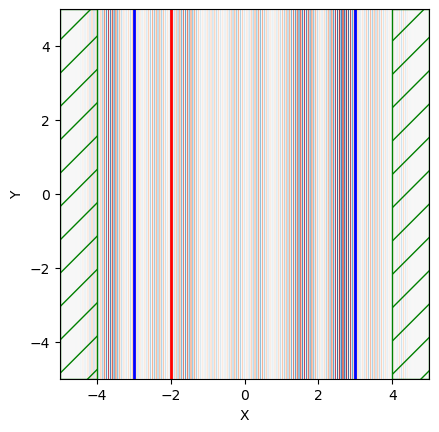

In [26]:
pml_layers = [mp.PML(thickness=1, direction = mp.X)]
cell_size = mp.Vector3(10,10)

fcen = (1/(0.40 * um_scale) + 1/(0.70 * um_scale))/2
df = 1 /(0.40 * um_scale) - 1/(0.70 * um_scale)
nfreq = 300

src = mp.GaussianSource(fcen,df)

sources = [mp.Source(src, component=mp.Ez, size=mp.Vector3(y=10), center=mp.Vector3(-2))]





geometry=[]


sim = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    k_point=mp.Vector3())

# reflected flux
refl_fr = mp.FluxRegion(
    center=mp.Vector3(-3, 0, 0), size=mp.Vector3(0, 10, 0)
)
refl = sim.add_flux(fcen, df, nfreq, refl_fr)

# transmitted flux
tran_fr = mp.FluxRegion(
    center=mp.Vector3(3, 0, 0), size=mp.Vector3(0, 10, 0)
)
tran = sim.add_flux(fcen, df, nfreq, tran_fr)



sim.run(until=100)

plt.figure(dpi=100)
sim.plot2D(fields=mp.Ez)
plt.show()

In [27]:
straight_refl_data = sim.get_flux_data(refl)
straight_tran_flux = mp.get_fluxes(tran)

In [28]:
sim.reset_meep()

-----------
Initializing structure...
time for choose_chunkdivision = 2.81334e-05 s
Working in 2D dimensions.
Computational cell is 10 x 10 x 0 with resolution 20
     block, center = (2,0,0)
          size (4,10,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.32,2.32,2.32)
time for set_epsilon = 0.0332129 s
lorentzian susceptibility: frequency=5.23857, gamma=0.321009
-----------


FloatProgress(value=0.0, description='0% done ')

run 0 finished at t = 100.0 (4000 timesteps)
     block, center = (2,0,0)
          size (4,10,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.32,2.32,2.32)


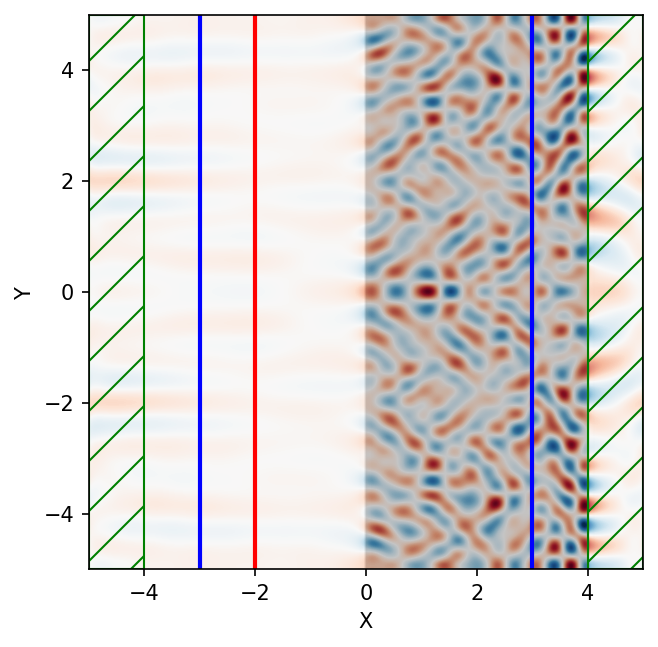

In [29]:
geometry = [mp.Block(
        mp.Vector3(4, 10, 0),
        center=mp.Vector3(2,0),
        material=SiN
    )]

sim = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    extra_materials=[SiN],
                    k_point=mp.Vector3())

# reflected flux
refl = sim.add_flux(fcen, df, nfreq, refl_fr)

tran = sim.add_flux(fcen, df, nfreq, tran_fr)

# for normal run, load negated fields to subtract incident from refl. fields
sim.load_minus_flux_data(refl, straight_refl_data)

sim.run(until=100)

bend_refl_flux = mp.get_fluxes(refl)
bend_tran_flux = mp.get_fluxes(tran)

flux_freqs = mp.get_flux_freqs(refl)

plt.figure(dpi=150)
sim.plot2D(fields=mp.Ez)
plt.show()

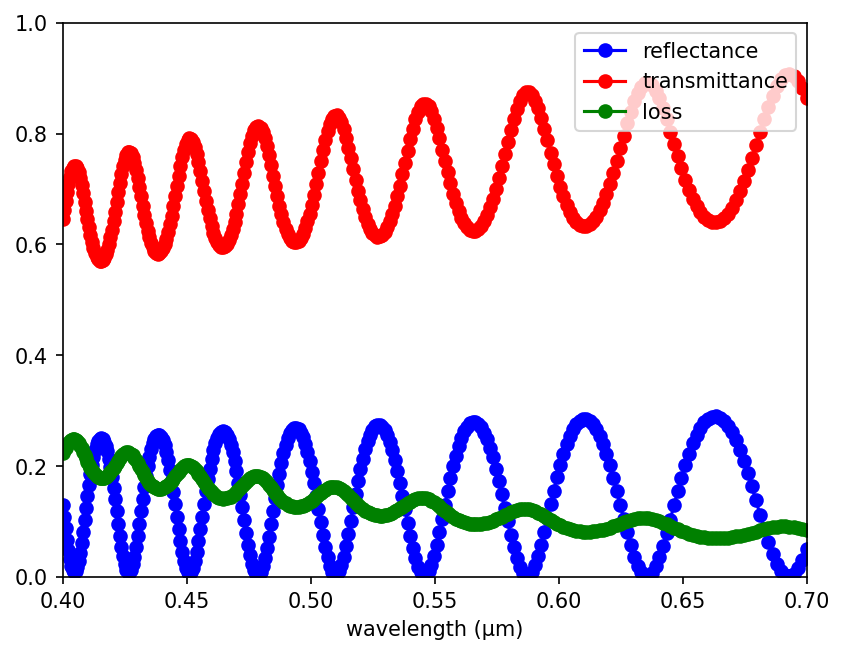

In [23]:
wl = [] #resolution 50
Rs = []
Ts = []
for i in range(nfreq):
    wl = np.append(wl, 1 / (flux_freqs[i] * um_scale))
    Rs = np.append(Rs, -bend_refl_flux[i] / straight_tran_flux[i])
    Ts = np.append(Ts, bend_tran_flux[i] / straight_tran_flux[i])

if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, Rs, "bo-", label="reflectance")
    plt.plot(wl, Ts, "ro-", label="transmittance")
    plt.plot(wl, 1 - Rs - Ts, "go-", label="loss")
    plt.axis([0.40, 0.70, 0, 1])
    plt.xlabel("wavelength (μm)")
    plt.legend(loc="upper right")
    plt.show()

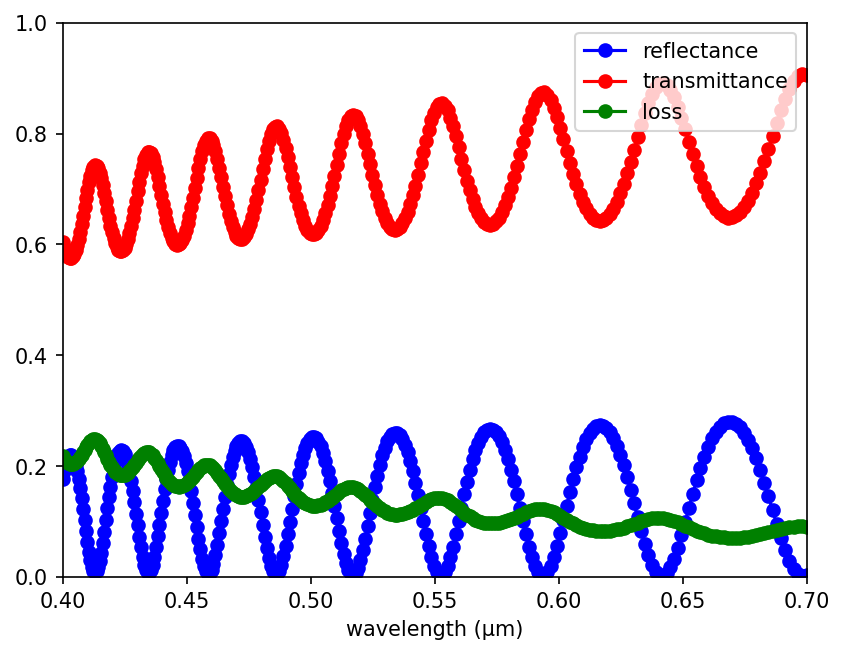

In [30]:
wl = [] #resolution20
Rs = []
Ts = []
for i in range(nfreq):
    wl = np.append(wl, 1 / (flux_freqs[i] * um_scale))
    Rs = np.append(Rs, -bend_refl_flux[i] / straight_tran_flux[i])
    Ts = np.append(Ts, bend_tran_flux[i] / straight_tran_flux[i])

if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, Rs, "bo-", label="reflectance")
    plt.plot(wl, Ts, "ro-", label="transmittance")
    plt.plot(wl, 1 - Rs - Ts, "go-", label="loss")
    plt.axis([0.40, 0.70, 0, 1])
    plt.xlabel("wavelength (μm)")
    plt.legend(loc="upper right")
    plt.show()